In [185]:
import requests
import pandas as pd
import numpy as np
import json
from census import Census
from us import states
import os
import re
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Data Extraction

## Requesting Data from Open Data Philly

The property characteristic and assessment history data in this analysis is sourced from [OpenDataPhilly]([https://opendataphilly.org/datasets/philadelphia-properties-and-assessment-history/), an online repository providing access to data about the Philadelphia region. The data is maintained by the City of Philadelhia's the Office of Property Assessment and contains records for all properties in Philadelphia.

The Property and Property Assessment datasets published to Carto and available to query via [SQL API](https://phl.carto.com/api/v2/sql) using PostgreSQL.
- **Property table**: opa_properties_public
- **Property Assessment table**: assessments

In [186]:
def requestOpenDataPhilly(query: str):
    '''
    Sends request to Open Data Philly's SQL API, and returns the results as a Pandas dataframe

    Args:
        query (str): query written in PostgreSQL

    Return:
        dataframe containing the results of the query
    '''
    print('Sending request to Open Data Philly API.')
    url = 'https://phl.carto.com/api/v2/sql'
    params = {'q':query}

    # send request
    response = requests.get(url, params=params)
    print(f"Open Data API Status Code: {response.status_code}")
    
    # sleep
    time.sleep(2)
    
    try:
        # convert response to df
        response_data = json.loads(str(response.text))                          
        data = response_data['rows']        
        print(f'Returning df for query: {query}.\n')                                    
        return pd.DataFrame.from_dict(data) 
    except:
        return pd.DataFrame() 




In [187]:
# establish queries
prop_query = "SELECT * FROM opa_properties_public" 
assess_2025 = "SELECT * FROM assessments WHERE year = '2025'"
assess_2024 = "SELECT * FROM assessments WHERE year = '2024'"
assess_2023 = "SELECT * FROM assessments WHERE year = '2023'"
assess_2022 = "SELECT * FROM assessments WHERE year = '2022'"
assess_2021 = "SELECT * FROM assessments WHERE year = '2021'"
assess_2020 = "SELECT * FROM assessments WHERE year = '2020'"
assess_2019 = "SELECT * FROM assessments WHERE year = '2019'"
assess_2018 = "SELECT * FROM assessments WHERE year = '2018'"
assess_2017 = "SELECT * FROM assessments WHERE year = '2017'"
assess_2016 = "SELECT * FROM assessments WHERE year = '2016'"
assess_2015 = "SELECT * FROM assessments WHERE year = '2015'"

In [188]:
# # get requests
# prop = requestOpenDataPhilly(prop_query)
# assess_2025 = requestOpenDataPhilly(assess_2025)
# assess_2024 = requestOpenDataPhilly(assess_2024)
# assess_2023 = requestOpenDataPhilly(assess_2023)
# assess_2022 = requestOpenDataPhilly(assess_2022)
# assess_2021 = requestOpenDataPhilly(assess_2021)
# assess_2020 = requestOpenDataPhilly(assess_2020)
# assess_2019 = requestOpenDataPhilly(assess_2019) 
# assess_2018 = requestOpenDataPhilly(assess_2018)  
# assess_2017 = requestOpenDataPhilly(assess_2017)
# assess_2016 = requestOpenDataPhilly(assess_2016)
# assess_2015 = requestOpenDataPhilly(assess_2015)

In [189]:
# # export files
# prop.to_csv("Data/properties.csv", index=False)
# assess_2025.to_csv("Data/assess_2025.csv", index=False)
# assess_2024.to_csv("Data/assess_2024.csv", index=False)
# assess_2023.to_csv("Data/assess_2023.csv", index=False)
# assess_2022.to_csv("Data/assess_2022.csv", index=False)
# assess_2021.to_csv("Data/assess_2021.csv", index=False)
# assess_2020.to_csv("Data/assess_2020.csv", index=False)
# assess_2019.to_csv("Data/assess_2019.csv", index=False)
# assess_2018.to_csv("Data/assess_2018.csv", index=False)
# assess_2017.to_csv("Data/assess_2017.csv", index=False)
# assess_2016.to_csv("Data/assess_2016.csv", index=False)
# assess_2015.to_csv("Data/assess_2015.csv", index=False)


In [190]:
# read csvs
prop = pd.read_csv("Data/properties.csv")
assess_2025 = pd.read_csv("Data/assess_2025.csv")
assess_2024 = pd.read_csv("Data/assess_2024.csv")
assess_2023 = pd.read_csv("Data/assess_2023.csv")
assess_2022 = pd.read_csv("Data/assess_2022.csv")
assess_2021 = pd.read_csv("Data/assess_2021.csv")
assess_2020 = pd.read_csv("Data/assess_2020.csv")
assess_2019 = pd.read_csv("Data/assess_2019.csv")
assess_2018 = pd.read_csv("Data/assess_2018.csv")
assess_2017 = pd.read_csv("Data/assess_2017.csv")
assess_2016 = pd.read_csv("Data/assess_2016.csv")
assess_2015 = pd.read_csv("Data/assess_2015.csv")

C:\Users\julia.f.flanagan\AppData\Local\Temp\ipykernel_8056\2771757085.py:2: DtypeWarning: Columns (6,18,29,78) have mixed types. Specify dtype option on import or set low_memory=False.
  prop = pd.read_csv("Data/properties.csv")


## Retrieving Real Estate Delinquency Data

Real Estate Delinquency data is available on Open Data Philly aggregated by location. To access this data at the parcel level, email Roman Stratkovsky <roman.stratkovsky@phila.gov>, Chief Data Intelligence Officer at the City of Philadelphia's Department of Revenue.

In [191]:
delinq = pd.read_csv("Data/real_estate_delinquency.csv")

# Data Cleaning

## Check the shape of each dataframe

In [192]:
# property df size
prop.shape

(580093, 81)

In [193]:
# assessment df size
for df in [assess_2025, assess_2024, assess_2023, assess_2022, assess_2021, assess_2020, assess_2019, assess_2018, assess_2017, assess_2016, assess_2015]:
    print(df.shape)

(580092, 10)
(579001, 10)
(578239, 10)
(577362, 10)
(576814, 10)
(576215, 10)
(574876, 10)
(573566, 10)
(573540, 10)
(573553, 10)
(573546, 10)


In [194]:
# real delinquency data
delinq.shape

(1400509, 7)

The property characteristics dataframe has 81 columns, many of which are of no relevance to Real Estate Delinquency. Therefore, a subset of the columns was selected based on institutional knowledge and relevance to the research question.

In [231]:
# create copy of properties df
prop_clean = prop.loc[:,['parcel_number', 'category_code_description','exterior_condition','interior_condition','homestead_exemption','mailing_zip','number_of_bathrooms'
                         ,'number_of_bedrooms','number_stories','sale_date','sale_price','total_area','total_livable_area','unit','year_built','zip_code']].copy(deep=True)

## Union and Pivot the Assessment dataframe

Assessment dataframes contain the property assessment for each year from 2015 to 2025. Union the individual dataframes then pivot the data so we can have a 1-year, 3-year, and 5-year look back for each property-year combination.

In [196]:
# create copies of the asessments df
assess_2025_clean = assess_2025.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2024_clean = assess_2024.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2023_clean = assess_2023.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2022_clean = assess_2022.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2021_clean = assess_2021.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2020_clean = assess_2020.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2019_clean = assess_2019.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2018_clean = assess_2018.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2017_clean = assess_2017.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2016_clean = assess_2016.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2015_clean = assess_2015.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)

In [197]:
# concat the assessment years together
assess_all = pd.concat([assess_2025_clean, assess_2024_clean, assess_2023_clean, assess_2022_clean, assess_2021_clean, assess_2020_clean, 
                        assess_2019_clean,assess_2018_clean, assess_2017_clean, assess_2016_clean, assess_2015_clean], axis=0, ignore_index=True)

# create taxable and exempt fields
assess_all['taxable'] = assess_all['taxable_land'] + assess_all['taxable_building']
assess_all['exempt'] = assess_all['exempt_land'] + assess_all['exempt_building']

# create fields for the 1, 3, and 5 year joins
assess_all['1yr'] = assess_all['year'] - 1
assess_all['3yr'] = assess_all['year'] - 3
assess_all['5yr'] = assess_all['year'] - 5

# select a subset of columns for each df
assess_1yr = assess_all.loc[:,['parcel_number','year','taxable','exempt']].copy(deep=True)
assess_3yr = assess_all.loc[:,['parcel_number','year','taxable','exempt']].copy(deep=True)
assess_5yr = assess_all.loc[:,['parcel_number','year','taxable','exempt']].copy(deep=True)

# rename columns to indicate the year of assessment
assess_1yr.rename(columns={'taxable':'taxable_1yr','exempt':'exempt_1yr'}, inplace=True)
assess_3yr.rename(columns={'taxable':'taxable_3yr','exempt':'exempt_3yr'}, inplace=True)
assess_5yr.rename(columns={'taxable':'taxable_5yr','exempt':'exempt_5yr'}, inplace=True)

In [198]:

# join to last year's assessments
assess_clean = pd.merge(assess_all, assess_1yr, how='inner', left_on=['parcel_number','1yr'], right_on=['parcel_number','year'])
assess_clean.drop(columns=['year_y'], inplace=True)
assess_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 3 years ago
assess_clean = pd.merge(assess_clean, assess_3yr, how='inner', left_on=['parcel_number','3yr'], right_on=['parcel_number','year'])
assess_clean.drop(columns=['year_y'], inplace=True)
assess_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 5 years ago
assess_clean = pd.merge(assess_clean, assess_5yr, how='inner', left_on=['parcel_number','5yr'], right_on=['parcel_number','year'])
assess_clean.drop(columns=['year_y'], inplace=True)
assess_clean.rename(columns={'year_x':'year'}, inplace=True)

# drop the additional year columns
assess_clean.drop(columns=['1yr','3yr','5yr'], inplace=True)

In [199]:
assess_clean.shape

(3445243, 15)

## Pivot Delinquent dataframe

Pivot table so there is one record per property (with delinquency from 2020 - 2024) instead of one record per property and year.

In [200]:
# create copy of the delinquency df
delinq_copy = delinq.loc[:,['parcel_number', 'snapshot_year', 'total_balance']].copy(deep=True)

In [201]:
# rename columns
delinq_copy.rename(columns={'snapshot_year':'year',
                            'total_balance':'total'},
                            inplace=True)

In [202]:
# drop years before 2015
delinq_copy = delinq_copy[delinq_copy.year >= 2015]

In [203]:
# create fields for the 1, 3, and 5 year joins
delinq_copy['1yr'] = delinq_copy['year'] - 1
delinq_copy['2yr'] = delinq_copy['year'] - 2
delinq_copy['3yr'] = delinq_copy['year'] - 3
delinq_copy['4yr'] = delinq_copy['year'] - 4
delinq_copy['5yr'] = delinq_copy['year'] - 5

# select a subset of columns for each df
delinq_1yr = delinq_copy.loc[:,['parcel_number', 'year', 'total']].copy(deep=True)
delinq_2yr = delinq_copy.loc[:,['parcel_number', 'year', 'total']].copy(deep=True)
delinq_3yr = delinq_copy.loc[:,['parcel_number', 'year', 'total']].copy(deep=True)
delinq_4yr = delinq_copy.loc[:,['parcel_number', 'year', 'total']].copy(deep=True)
delinq_5yr = delinq_copy.loc[:,['parcel_number', 'year', 'total']].copy(deep=True)

# rename columns to indicate the year of assessment
delinq_1yr.rename(columns={'total':'total_1yr'}, inplace=True)
delinq_2yr.rename(columns={'total':'total_2yr'}, inplace=True)
delinq_3yr.rename(columns={'total':'total_3yr'}, inplace=True)
delinq_4yr.rename(columns={'total':'total_4yr'}, inplace=True)
delinq_5yr.rename(columns={'total':'total_5yr'}, inplace=True)


In [204]:
# join to last year's assessments
delinq_clean = pd.merge(delinq_copy, delinq_1yr, how='left', left_on=['parcel_number','1yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 2 years ago
delinq_clean = pd.merge(delinq_clean, delinq_2yr, how='left', left_on=['parcel_number','2yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 3 years ago
delinq_clean = pd.merge(delinq_clean, delinq_3yr, how='left', left_on=['parcel_number','3yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 4 years ago
delinq_clean = pd.merge(delinq_clean, delinq_4yr, how='left', left_on=['parcel_number','4yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 5 years ago
delinq_clean = pd.merge(delinq_clean, delinq_5yr, how='left', left_on=['parcel_number','5yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# drop the additional year columns
delinq_clean.drop(columns=['1yr','2yr','3yr','4yr','5yr'], inplace=True)

Records in the Delinquency dataframe that don't have a delinquent Real Estate tax balance have missing values. Fill those missing values with 0s.

In [205]:
delinq_clean.fillna(0, inplace=True)

In [206]:
delinq_clean.shape

(813883, 8)

## Fix inconsistent data types

In [207]:
prop_clean.dtypes

parcel_number                  int64
category_code_description     object
exterior_condition            object
interior_condition            object
homestead_exemption            int64
mailing_zip                   object
number_of_bathrooms          float64
number_of_bedrooms           float64
number_stories               float64
sale_date                     object
sale_price                   float64
total_area                   float64
total_livable_area           float64
unit                          object
year_built                   float64
zip_code                     float64
dtype: object

Exterior condition is a numerical scale from 1 to 9 where 1 indicates newer construction, 9 indicates properties that are structurally compromised, and 0 indicates that exterior condition is not applicable. Remove errornous values, change 0s to NAs, and convert to float type.

In [208]:
# check unique values for exterior condition
prop_clean.exterior_condition.unique()

# 6 records where exterior condition is an invalid value
prop_clean[prop_clean.exterior_condition.isin(['P','E','A'])].head(10)

# change invalid records to NA
prop_clean.loc[(prop_clean.exterior_condition.isin(['P','E','A'])), 'exterior_condition'] = np.nan

# convert exterior condition to float
prop_clean.exterior_condition = prop_clean.exterior_condition.astype(float)

# change 0 (not applicable) records to NA
prop_clean.loc[(prop_clean.exterior_condition == 0), 'exterior_condition'] = np.nan

# confirm unqiue values of exterior condition
prop_clean.exterior_condition.unique()

array([ 4.,  5.,  3., nan,  1.,  2.,  6.,  7.,  8.])

Interior condition is a numerical scale from 1 to 8 where 1 indicates newer construction, 7 indicates properties that are structurally compromised, and 0 indicates that interior condition is not applicable. Remove errornous values, change 0s to NAs, and convert to float type.

In [209]:
# check unique values for interior condition
prop_clean.interior_condition.unique()

# 6 records where exterior condition is an invalid value
prop_clean[prop_clean.interior_condition.isin(['P','E','A'])].head(10)

# change invalid records to NA
prop_clean.loc[(prop_clean.interior_condition.isin(['P','E','A'])), 'interior_condition'] = np.nan

# convert interior condition to float
prop_clean.interior_condition = prop_clean.interior_condition.astype(float)

# change 0 (not applicable) records to NA
prop_clean.loc[(prop_clean.interior_condition == 0), 'interior_condition'] = np.nan

# confirm unqiue values of exterior condition
prop_clean.interior_condition.unique()

array([ 4.,  3., nan,  5.,  1.,  2.,  7.,  6.,  8.])

Unit, if exists, is a condo unit number. We care whether of not a property is a condo so we will convert unit to a boolean.

In [245]:
prop_clean.unit = prop_clean.unit.apply(lambda x: 0 if pd.isna(x) else 1)

In [107]:
# convert from float to int for count data
prop_clean.number_of_bathrooms = prop_clean.number_of_bathrooms.astype('Int64')
prop_clean.number_of_bedrooms = prop_clean.number_of_bedrooms.astype('Int64')
prop_clean.number_stories = prop_clean.number_stories.astype('Int64')

# convert year built from float to string and remove floating point values
prop_clean.year_built = prop_clean.year_built.apply(lambda x: np.nan if pd.isna(x) else str(x)[:-2])

# convert zip code from float to string and remove floating point values
prop_clean.zip_code = prop_clean.zip_code.apply(lambda x: np.nan if pd.isna(x) else str(x)[:-2])

# convert from object to date
prop_clean.sale_date = pd.to_datetime(prop_clean.sale_date, format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

In [108]:
prop_clean.dtypes

parcel_number                         int64
category_code_description            object
exterior_condition                  float64
interior_condition                  float64
homestead_exemption                   int64
mailing_zip                          object
number_of_bathrooms                   Int64
number_of_bedrooms                    Int64
number_stories                        Int64
sale_date                    datetime64[ns]
sale_price                          float64
total_area                          float64
total_livable_area                  float64
unit                                  int64
year_built                           object
zip_code                             object
dtype: object

In [109]:
assess_2025_clean.dtypes

parcel_number         int64
year                  int64
market_value          int64
taxable_land        float64
taxable_building    float64
exempt_land         float64
exempt_building     float64
dtype: object

In [110]:
delinq_clean.dtypes

parcel_number      int64
year               int64
total            float64
total_1yr        float64
total_2yr        float64
total_3yr        float64
total_4yr        float64
total_5yr        float64
dtype: object

## Handle missing values in the Property dataset

The property characteristics dataset is rife with missing values due to the method of data collection. This dataset is supported and maintained by the City of Philadelphia’s Office of Property Assessment (OPA). According to the OPA Mass Appraisal [Methodology Documentation](https://www.phila.gov/media/20240920162052/opa-tax-year-2025-mass-appraisal-valuation-methodology.pdf), data on individual properties is collected by OPA evaluators either in-person or virtually. In-person data collections consist of physically visiting a property and collecting observations from the curb. OPA evaluators may only conduct an internal inspection if they are invited in by an occupant. Virtual inspections are conducted by utilizing aerial photography or online listings. Therefore, data is limited by circumstance and online availability.

In [111]:
# count missing values
prop_clean.isna().sum()

parcel_number                    0
category_code_description       13
exterior_condition           42595
interior_condition           42621
homestead_exemption              0
mailing_zip                   2156
number_of_bathrooms          83510
number_of_bedrooms           79980
number_stories               71914
sale_date                     1063
sale_price                    1077
total_area                     247
total_livable_area           42228
unit                             0
year_built                   42227
zip_code                       145
dtype: int64

### Many missing values are coming from vacant properties

There are around 42,000 missing values for exterior condition, interior condition, number of bathrooms, number of bedrooms, number of stories, total livable area, and year built where the property is vacant. Vacant properties don't have bathrooms, bedrooms, stories, livable areas, or a year built since there is no structure. Therefore, we must correct these values.

In [112]:
prop_clean[prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])].isna().sum()

parcel_number                    0
category_code_description        0
exterior_condition           42010
interior_condition           42013
homestead_exemption              0
mailing_zip                     76
number_of_bathrooms          41971
number_of_bedrooms           41970
number_stories               42017
sale_date                      266
sale_price                     271
total_area                      98
total_livable_area           41912
unit                             0
year_built                   41912
zip_code                       109
dtype: int64

### Fix records for vacant properties

In [113]:
# change the bathrooms from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.number_of_bathrooms.isna()), 'number_of_bathrooms'] = 0

# change the bedrooms from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.number_of_bedrooms.isna()), 'number_of_bedrooms'] = 0

# change the stories from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.number_stories.isna()), 'number_stories'] = 0

# change the total livable area from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.total_livable_area.isna()), 'total_livable_area'] = 0

# change year built to 2029
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.year_built.isna()), 'year_built'] = 2029


Exterior conditions is a numerical scale from 1 to 9 where 1 indicates newer construction and 9 indictates properties that are structurally compromised. Therefore, we will change NA to 10 for vacant properties. 

In [114]:
# change the exterior condition from NA to 10 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.exterior_condition.isna()), 'exterior_condition'] = 10

Interior condition is a numerical scale from 1 to 7 where 1 is new and or newly rehabed and 7 is structurally compromised. Therefore, we will change NA to 9 for vacant properties.

In [115]:
# change the interior condition from NA to 8 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.interior_condition.isna()), 'interior_condition'] = 9

In [116]:
prop_clean[prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])].isna().sum()

parcel_number                  0
category_code_description      0
exterior_condition             0
interior_condition             0
homestead_exemption            0
mailing_zip                   76
number_of_bathrooms            0
number_of_bedrooms             0
number_stories                 0
sale_date                    266
sale_price                   271
total_area                    98
total_livable_area             0
unit                           0
year_built                     0
zip_code                     109
dtype: int64

There still exists many records with the number of bedrooms, bathrooms, and stories missing. 

In [117]:
prop_clean.isna().sum()

parcel_number                    0
category_code_description       13
exterior_condition             585
interior_condition             608
homestead_exemption              0
mailing_zip                   2156
number_of_bathrooms          41539
number_of_bedrooms           38010
number_stories               29897
sale_date                     1063
sale_price                    1077
total_area                     247
total_livable_area             316
unit                             0
year_built                     315
zip_code                       145
dtype: int64

As discussed earlier, missing values for number of bedrooms, bathrooms, and stories in the OPA property dataset are a result of circumstance and online availability. The unavailability of these variables seems to follow a pattern with the category code description. Single family and multifamily homes are more likely to have counts of bedrooms and bathrooms than other non-residential building types. Simiarly, commercial, industrial, and mixed use properties tend to have missing values for number of stories. This is most likely because online real estate marketplaces like Zillow advertise or estimate the number of bedrooms, bathrooms, and bathrooms for residential properties. Therefore, we suspect that the missingness of these variables is random, but not completely random. 

In [118]:
# counts by category code description
prop_clean[['parcel_number','number_of_bedrooms','number_of_bathrooms','number_stories']].groupby(prop_clean.category_code_description).agg(['count']) 

,parcel_number,number_of_bedrooms,number_of_bathrooms,number_stories
,count,count,count,count
category_code_description,,,,
APARTMENTS > 4 UNITS,3222,91,84,3012
COMMERCIAL,12550,28,25,261
GARAGE - COMMERCIAL,105,25,27,61
GARAGE - RESIDENTIAL,564,514,514,533
HOTEL,127,1,0,110
INDUSTRIAL,4032,4,4,557
MIXED USE,14247,205,187,1141
MULTI FAMILY,40977,38231,37675,40605


In [119]:
# count, mean, and mode for number of bedrooms by building category
prop_clean[['number_of_bedrooms']].groupby(prop_clean.category_code_description).agg(['count','mean', 'median', pd.Series.mode]) 

number_of_bedrooms                         
                                           count      mean median    mode
category_code_description                                                
APARTMENTS  > 4 UNITS                         91  3.593407    0.0       0
COMMERCIAL                                    28  0.857143    0.0       0
GARAGE - COMMERCIAL                           25      0.64    0.0       0
GARAGE - RESIDENTIAL                         514  0.031128    0.0       0
HOTEL                                          1       8.0    8.0       8
INDUSTRIAL                                     4      0.75    0.0       0
MIXED USE                                    205  2.253659    3.0       0
MULTI FAMILY                               38231  1.846747    0.0       0
OFFICES                                        3       0.0    0.0       0
RETAIL                                         2       1.0    1.0  [0, 2]
SINGLE FAMILY                             460709  2.487275    3.0       3
SPECIAL PURPOSE                               11       1.0    0.0       0
VACANT LAND                                41182  0.006338    0.0       0
VACANT LAND - NON-RESIDENTIAL                102       0.0    0.0       0
VACANT LAND - RESIDENTIAL                    973   0.02261    0.0       0

In [120]:
# count, mean, and mode for number of bathrooms by building category
prop_clean[['number_of_bathrooms']].groupby(prop_clean.category_code_description).agg(['count','mean', 'median', pd.Series.mode]) 

number_of_bathrooms                         
                                            count      mean median    mode
category_code_description                                                 
APARTMENTS  > 4 UNITS                          84  2.285714    0.0       0
COMMERCIAL                                     25      0.32    0.0       0
GARAGE - COMMERCIAL                            27  0.259259    0.0       0
GARAGE - RESIDENTIAL                          514  0.013619    0.0       0
HOTEL                                           0      <NA>   <NA>      []
INDUSTRIAL                                      4      0.25    0.0       0
MIXED USE                                     187  1.149733    1.0       0
MULTI FAMILY                                37675  0.997319    0.0       0
OFFICES                                         3       0.0    0.0       0
RETAIL                                          2       0.5    0.5  [0, 1]
SINGLE FAMILY                              457763  0.979039    1.0       1
SPECIAL PURPOSE                                11  0.454545    0.0       0
VACANT LAND                                 41182  0.002647    0.0       0
VACANT LAND - NON-RESIDENTIAL                 102       0.0    0.0       0
VACANT LAND - RESIDENTIAL                     973  0.007194    0.0       0

In [121]:
# count, mean, and mode for number of stories by building category
prop_clean[['number_stories']].groupby(prop_clean.category_code_description).agg(['count','mean', 'median', pd.Series.mode]) 

number_stories                      
                                       count      mean median mode
category_code_description                                         
APARTMENTS  > 4 UNITS                   3012  3.817729    3.0    3
COMMERCIAL                               261  2.218391    2.0    1
GARAGE - COMMERCIAL                       61  2.688525    1.0    1
GARAGE - RESIDENTIAL                     533   1.02439    1.0    1
HOTEL                                    110  8.672727    5.0    4
INDUSTRIAL                               557  1.572711    1.0    1
MIXED USE                               1141  2.581946    3.0    3
MULTI FAMILY                           40605   2.37286    2.0    2
OFFICES                                  710  4.771831    3.0    1
RETAIL                                     9  1.777778    1.0    1
SINGLE FAMILY                         460916  1.912177    2.0    2
SPECIAL PURPOSE                           17  2.176471    2.0    2
VACANT LAND                            41182  0.006022    0.0    0
VACANT LAND - NON-RESIDENTIAL            102       0.0    0.0    0
VACANT LAND - RESIDENTIAL                973  0.124358    0.0    0

### Impute or drop missing values in the property dataset

We will impute the missing values of number of bedrooms, bathrooms, and stories with a stratified imputation. Based on subject matter knowledge, we will round the number of bedrooms down, the number of bathrooms up, and the number of stories to the closest digit to have interger counts.

In [122]:
prop_clean.number_of_bedrooms = prop_clean.groupby('category_code_description')['number_of_bedrooms'].transform(lambda x: x.fillna(value= math.floor(x.mean())))

In [123]:
prop_clean.number_of_bathrooms = prop_clean.groupby('category_code_description')['number_of_bathrooms'].transform(lambda x: x.fillna(math.ceil(x.mean())) if not pd.isna(x.mean()) else x)

In [124]:
prop_clean.number_stories = prop_clean.groupby('category_code_description')['number_stories'].transform(lambda x: x.fillna(value= round(x.mean())))

In [125]:
prop_clean.isna().sum()

parcel_number                   0
category_code_description      13
exterior_condition            585
interior_condition            608
homestead_exemption             0
mailing_zip                  2156
number_of_bathrooms           140
number_of_bedrooms             13
number_stories                 13
sale_date                    1063
sale_price                   1077
total_area                    247
total_livable_area            316
unit                            0
year_built                    315
zip_code                      145
dtype: int64

In [126]:
# count the number of records that would be dropped if any records with missing values were dropped
len(prop_clean[prop_clean.isna().any(axis = 'columns')])

4100

We will drop the rest of the records with missing values since missingness in the property dataset is a random or completely random and less then 5% of the records would be dropped.

In [127]:
# drop missing records
prop_clean.dropna(inplace=True)

In [128]:
# check missing values
prop_clean.isna().sum()

parcel_number                0
category_code_description    0
exterior_condition           0
interior_condition           0
homestead_exemption          0
mailing_zip                  0
number_of_bathrooms          0
number_of_bedrooms           0
number_stories               0
sale_date                    0
sale_price                   0
total_area                   0
total_livable_area           0
unit                         0
year_built                   0
zip_code                     0
dtype: int64

## Handle missing values in the Property Assessment dataset

In [129]:
assess_clean.isna().sum()

parcel_number       0
year                0
market_value        0
taxable_land        1
taxable_building    3
exempt_land         0
exempt_building     0
taxable             4
exempt              0
taxable_1yr         5
exempt_1yr          0
taxable_3yr         2
exempt_3yr          0
taxable_5yr         1
exempt_5yr          0
dtype: int64

In [130]:
assess_clean[assess_clean.taxable_building.isna()]

,parcel_number,year,market_value,taxable_land,taxable_building,exempt_land,exempt_building,taxable,exempt,taxable_1yr,exempt_1yr,taxable_3yr,exempt_3yr,taxable_5yr,exempt_5yr
1263074,191397500,2023,408000,89700.0,NaN,318300.0,0.0,NaN,318300.0,59800.0,0.0,59800.0,0.0,59800.0,0.0
1336932,302150100,2023,256000,61200.0,NaN,194800.0,0.0,NaN,194800.0,61200.0,194800.0,61200.0,194800.0,256000.0,0.0
1687933,885948280,2023,317500,317500.0,NaN,0.0,0.0,NaN,0.0,245300.0,0.0,204417.0,40883.0,0.0,108900.0


The final assessment table is the result of inner joins, so we have all properties that have an assessment for the past 5 years. Missing values here seem to be the result of input error so we will drop those records.

In [131]:
assess_clean.dropna(inplace=True)

## Handle missing values in the Delinquency dataframe

The delinquency dataset has no missing values, as a missing value would indicate no Real Estate Tax delinquency,

In [132]:
delinq_clean.isna().sum()

parcel_number    0
year             0
total            0
total_1yr        0
total_2yr        0
total_3yr        0
total_4yr        0
total_5yr        0
dtype: int64

## Outlier Detection

### Visualize the distribution of numeric variables using boxplots

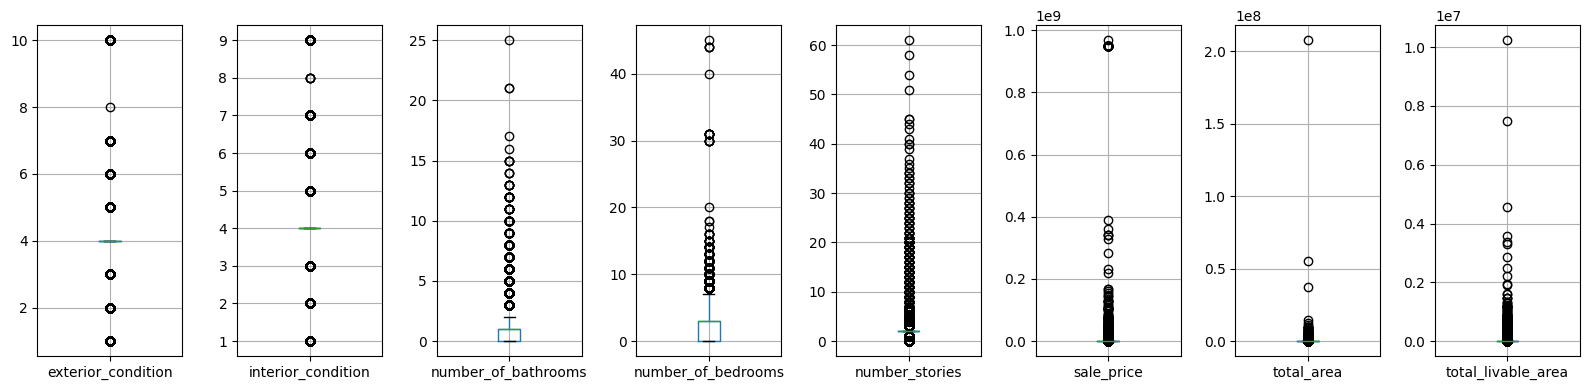

In [ ]:
## need 100 sq feet per bedroom and 300 sq feet per bathroom for outliers ?
columns_for_boxplots = ['exterior_condition', 'interior_condition', 'number_of_bathrooms', 'number_of_bedrooms', 'number_stories', 'sale_price', 'total_area', 'total_livable_area']
fig, ax = plt.subplots(nrows= 1, ncols= len(columns_for_boxplots), figsize= (16, 4))

i = 0
for col in columns_for_boxplots:
    prop_clean.boxplot(column=col, ax= ax[i]) #[prop_clean.category_code_description == 'SINGLE FAMILY']
    i += 1
plt.tight_layout()
plt.show() 

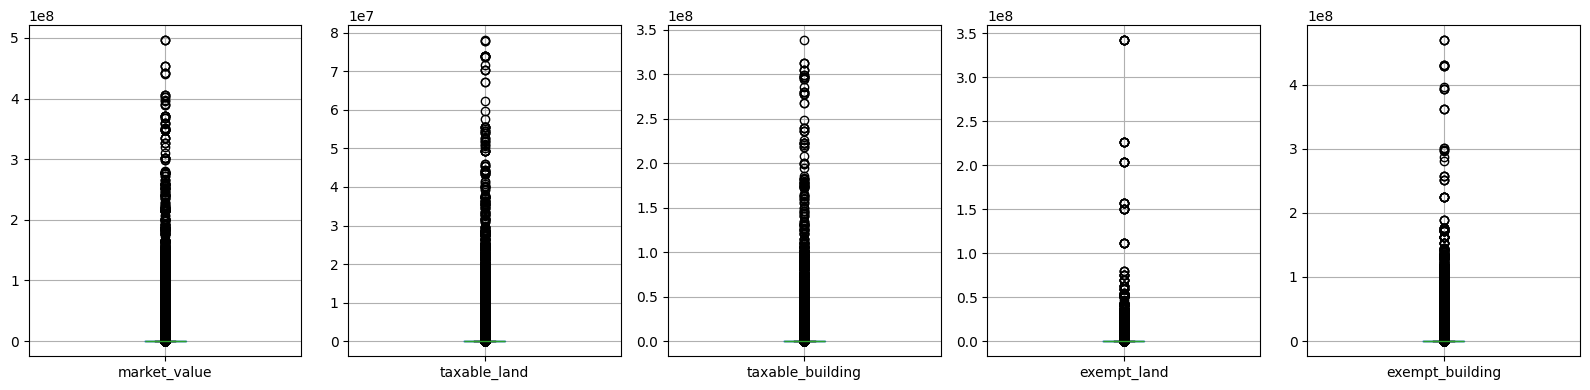

In [ ]:
columns_for_boxplots = ['market_value','taxable_land','taxable_building','exempt_land','exempt_building']
fig, ax = plt.subplots(nrows= 1, ncols= len(columns_for_boxplots), figsize= (16, 4))

i = 0
for col in columns_for_boxplots:
    assess_clean.boxplot(column=col, ax= ax[i])
    i += 1
plt.tight_layout()
plt.show() 

In [171]:
delinq_clean.dtypes

parcel_number      int64
year               int64
total            float64
total_1yr        float64
total_2yr        float64
total_3yr        float64
total_4yr        float64
total_5yr        float64
dtype: object

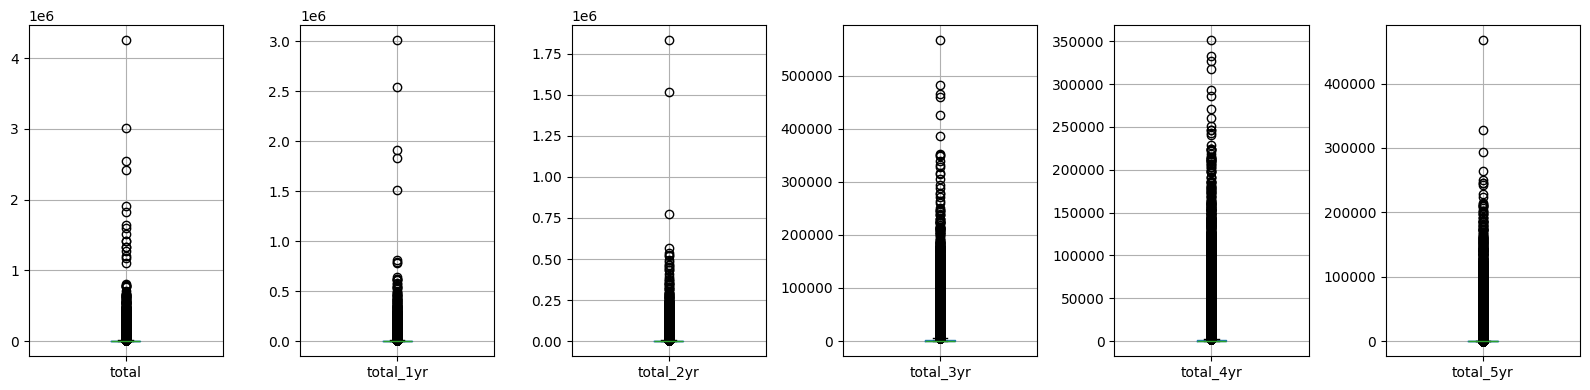

In [ ]:
columns_for_boxplots = ['total','total_1yr','total_2yr','total_3yr','total_4yr','total_5yr']
fig, ax = plt.subplots(nrows= 1, ncols= len(columns_for_boxplots), figsize= (16, 4))

i = 0
for col in columns_for_boxplots:
    delinq_clean.boxplot(column=col, ax= ax[i])
    i += 1
plt.tight_layout()
plt.show() 

## Correct Outliers

In [251]:
prop_clean[(prop_clean.category_code_description == 'SINGLE FAMILY') & (prop_clean.number_of_bedrooms > 7)].head(10)


,parcel_number,category_code_description,exterior_condition,interior_condition,homestead_exemption,mailing_zip,number_of_bathrooms,number_of_bedrooms,number_stories,sale_date,sale_price,total_area,total_livable_area,unit,year_built,zip_code,test
2792,131010800,SINGLE FAMILY,6,6,0,19123,3.0,8.0,3.0,2024-11-27T05:00:00Z,1.0,2458.0,2928.0,0,1930.0,19140.0,0
4575,111103800,SINGLE FAMILY,4,5,0,19020,2.0,9.0,2.0,2024-10-28T04:00:00Z,75000.0,2588.0,2313.0,0,1925.0,19132.0,0
5532,122146600,SINGLE FAMILY,4,4,100000,19144-5802,4.0,9.0,3.0,2024-09-12T04:00:00Z,544000.0,17700.0,4410.0,0,1900.0,19144.0,0
6974,344161800,SINGLE FAMILY,4,4,0,19151-2516,3.0,8.0,3.0,2024-10-04T04:00:00Z,585000.0,12000.0,4320.0,0,1925.0,19151.0,0
7373,81038100,SINGLE FAMILY,4,4,0,19103-6502,3.0,9.0,3.0,2024-07-25T04:00:00Z,1.0,1621.0,4291.0,0,1850.0,19103.0,0
14479,122070005,SINGLE FAMILY,4.0,5.0,0,19082,4.0,9.0,3.0,2024-05-02T04:00:00Z,318000.0,39282.0,4320.0,0,1925.0,19144.0,0
16381,344197200,SINGLE FAMILY,5.0,6.0,0,19121,3.0,12.0,1.0,2024-03-19T04:00:00Z,235000.0,6150.0,3927.0,0,1925.0,19151.0,0
17967,213265200,SINGLE FAMILY,4.0,4.0,100000,19119-3728,6.0,8.0,3.0,2024-02-01T05:00:00Z,2425000.0,160736.0,9024.0,0,1900.0,19119.0,0
21611,112319300,SINGLE FAMILY,4.0,4.0,0,08525,4.0,8.0,1.0,2023-11-15T05:00:00Z,641000.0,1600.0,2600.0,0,1940.0,19140.0,0
25531,223009100,SINGLE FAMILY,4.0,4.0,100000,19119-3601,4.0,8.0,3.0,2023-10-06T04:00:00Z,1.0,10128.0,5024.0,0,1925.0,19119.0,0


## Examine skewness

In [ ]:
prop_clean[['exterior_condition', 'interior_condition', 'number_of_bathrooms', 'number_of_bedrooms', 'number_stories', 'sale_price', 'total_area', 'total_livable_area']].skew()

exterior_condition       2.428174
interior_condition       2.079992
number_of_bathrooms       1.71057
number_of_bedrooms        0.15688
number_stories           6.253743
sale_price              92.505504
total_area             617.385175
total_livable_area     183.094911
dtype: Float64

In [178]:
assess_clean[['market_value','taxable_land','taxable_building','exempt_land','exempt_building']].skew()

market_value         67.795182
taxable_land         71.818965
taxable_building    105.302287
exempt_land         233.895647
exempt_building     104.616251
dtype: float64

In [179]:
delinq_clean[['total','total_1yr','total_2yr','total_3yr','total_4yr','total_5yr']].skew()

total        74.527325
total_1yr    62.857186
total_2yr    27.368318
total_3yr    10.060239
total_4yr     9.040807
total_5yr     9.899340
dtype: float64

# Feature Extraction

## Feature Engineer Input Variables

In [ ]:
# reformat the category_code_description column and create dummies
prop_clean.category_code_description = prop_clean.category_code_description.apply(lambda x: None if x == None else x.split('-')[0].strip().replace(' ', '_').lower()) 
prop_clean = pd.get_dummies(prop_clean, columns=['category_code_description'], prefix= '', prefix_sep='')

# create indicator for homestead exemption
prop_clean['homestead_exemption'] = prop_clean.homestead_exemption.apply(lambda x: 0 if x < 1 else 1)

# create indicator for mailing zip outside of the city limits
prop_clean['mailing_outside_city'] = prop_clean.mailing_zip.apply(lambda x: 0 if x == None else (0 if x[:3] == '191' else 1))

# view total libable area by number of bedrooms
prop_clean.total_livable_area.groupby(prop_clean['number_of_bedrooms']).describe() ## bedrooms over 30 are incorrect
prop_clean.total_livable_area.groupby(prop_clean['number_of_bathrooms']).describe() ## bathrooms over 20 are incorrect

# indicator for whether a property has a condo unit
prop_clean['condo'] = prop_clean['unit'].apply(lambda x: 0 if x == None else 1)

## Correlation Analysis

# Data Exploration